**9. Analysing Offensive Value added by left and right footed players in different regions**<br>
We have tried to understand how different players fare on accuracy (number of accurate progressive passes in a particular region / total progressive passes in that region) vs preference (number of progressive passes in a region/ total progressive passes made). We have further analysed the offensive value that each player adds in different region for accurate progressive passes, inaccurate progressive passes and total progressive passes.

The following tasks have been taken into account in this notebook:

1. Extract progressive passes and VAEP, offensive and defensive values and filter them bases on the regions

2. Compute accuracy and preference for progressive passes in each region for a particular player and plot it for every region

3. Compute offensive value added per accurate progressive pass and plot it with preference of making an accurate progressive pass in each region. Perform the same activity for inaccurate passes as well

4. Compute offensive value added per progressive pass (accurate and inaccurate) and plot it with preference of making a progressive pass in each region

The following results have been saved:

1. Plots for preference vs accuracy

2. Plots for accurate progressive pass preference vs offensive value added per accurate progressive pass

3. Plots for inaccurate progressive pass preference vs offensive value added per inaccurate progressive pass

4. Plots for progressive pass preference vs offensive value added per progressive pass


Note: The column names for the dataframe used for plotting have been explained in the `Appendix` section



# Imports 

In [63]:
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
import statistics
pd.set_option('max_columns',1000)

# Data 

In [64]:
# Reading defender wise passing attributes dataset
defender_attrs = pd.read_pickle(
    '../../FootballPlayerFootedness_copy/data/defender_clusters/defender_clustering_dataset.pkl'
)

In [65]:
# # Filtering out left center backs from this dataset for both 4 at the back and non 4 at the back formations
# defender_attrs_lcb = defender_attrs.loc[(defender_attrs['position']=='LCB') | (defender_attrs['position']=='L_CB')]

In [66]:
defender_attrs.head()

player_name            team position footedness  passes  accpass  \
0   AaronCresswell        West Ham       LB       left     275      203   
1   AaronCresswell        West Ham      LCB       left     796      644   
2  AaronWanBissaka  Crystal Palace       RB      right     226      165   
3        AdamSmith     Bournemouth       LB      right     146      120   
4        AdamSmith     Bournemouth       RB      right     451      387   

                                          accpassloc  \
0  [[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58.4...   
1  [[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....   
2  [[[60.32, 11.56], [70.72, 8.84]], [[55.12, 11....   
3  [[[15.6, 59.84], [22.88, 54.4]], [[19.76, 61.2...   
4  [[[28.08, 4.76], [40.56, 20.4]], [[31.2, 13.6]...   

                                        inaccpassloc  \
0  [[[22.88, 65.28], [31.2, 63.24]], [[24.96, 61....   
1  [[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...   
2  [[[86.32, 22.44], [87.36, 25.84]], [[98.8, 10....   
3  [[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.72...   
4  [[[55.12, 4.08], [62.4, 6.8]], [[35.36, 4.08],...   

                                         accpassvaep  \
0  [-0.0060007767751812935, 0.014951384626328945,...   
1  [0.0010694738011807203, 0.002371369395405054, ...   
2  [0.0027392818592488766, -0.0019667267333716154...   
3  [-0.002463837619870901, -0.0001035716850310564...   
4  [0.0007454273290932178, -0.002337034558877349,...   

                                       inaccpassvaep  \
0  [-0.005001368001103401, 0.0014556727837771177,...   
1  [-0.00956201646476984, -0.007710381411015987, ...   
2  [-0.02877645380795002, -0.01624043844640255, -...   
3  [-0.007104361429810524, 1.648860052227974e-05,...   
4  [-0.008189908228814602, 0.0007318942807614803,...   

                                          accpassoff  \
0  [-0.00111871468834579, 0.0030969707295298576, ...   
1  [0.0018120664171874523, 0.002711281180381775, ...   
2  [0.002814173698425293, -0.0016991370357573032,...   
3  [-0.005229263566434383, 0.0009387347381561995,...   
4  [0.0013971277512609959, -0.0004184735007584095...   

                                        inaccpassoff  \
0  [-0.0018319590017199516, 0.0011951092164963484...   
1  [-0.006647953763604164, -0.006097717210650444,...   
2  [-0.027683690190315247, -0.01549511682242155, ...   
3  [-0.005188643001019955, 0.0009281975217163563,...   
4  [-0.005722924135625362, 0.0007222630083560944,...   

                                          accpassdef  \
0  [-0.00488206185400486, 0.011854413896799088, 0...   
1  [-0.0007425926742143929, -0.000339911784976720...   
2  [-7.489195559173822e-05, -0.000267589697614312...   
3  [0.0027654259465634823, -0.0010423064231872559...   
4  [-0.000651700422167778, -0.0019185610581189394...   

                                        inaccpassdef  matches_played  
0  [-0.003169409232214093, 0.00026056356728076935...             7.0  
1  [-0.002914062701165676, -0.001612664433196187,...            20.0  
2  [-0.0010927643161267042, -0.000745321158319711...             7.0  
3  [-0.0019157183123752475, -0.000911708921194076...             3.0  
4  [-0.0024669840931892395, 9.631272405385971e-06...            10.0

# Filtering for Progressive Values

In [67]:
# Function to get start and end location points for every row in df
def getstartend(locs):
    end_points = list()
    start_points = list()
    for point in locs:
            if point != []:
                end_points.append(point[1])
                start_points.append(point[0])
    return start_points,end_points

In [68]:
# Function to segregate progressive passes for every row of pass location column
def distfilter(locs,vaeps):
    loc_start, loc_end = getstartend(locs)
    progpass = 0
    prog_passlocs = list()
    prog_passvaeps = list()
    for p1,p2,vaep in zip(loc_start,loc_end,vaeps):
        dist = np.round(np.linalg.norm(np.array(p1) - np.array(p2)),2)
        if p1[0] < 52 and dist >= 30 and p1[0] < p2[0]:
            prog_passlocs.append([np.round(p1,2),np.round(p2,2)])
            prog_passvaeps.append(vaep)
        elif p1[0] > 52 and dist >= 10 and p1[0] < p2[0]:
            prog_passlocs.append([np.round(p1,2),np.round(p2,2)])
            prog_passvaeps.append(vaep)
    progpass = len(prog_passlocs)
    return pd.Series([prog_passlocs,prog_passvaeps,progpass])
            

In [69]:
defender_attrs[[
    'progaccpassloc', 'progaccpassvaep', 'progaccpass'
]] = defender_attrs.apply(
    lambda x: distfilter(x['accpassloc'], x['accpassvaep']), axis=1)

defender_attrs[[
    'proginaccpassloc', 'proginaccpassvaep', 'proginaccpass'
]] = defender_attrs.apply(
    lambda x: distfilter(x['inaccpassloc'], x['inaccpassvaep']), axis=1)

defender_attrs[[
    'progaccpassloc', 'progaccpassoff', 'progaccpass'
]] = defender_attrs.apply(
    lambda x: distfilter(x['accpassloc'], x['accpassoff']), axis=1)

defender_attrs[[
    'proginaccpassloc', 'proginaccpassoff', 'proginaccpass'
]] = defender_attrs.apply(
    lambda x: distfilter(x['inaccpassloc'], x['inaccpassoff']), axis=1)

defender_attrs[[
    'progaccpassloc', 'progaccpassdef', 'progaccpass'
]] = defender_attrs.apply(
    lambda x: distfilter(x['accpassloc'], x['accpassdef']), axis=1)

defender_attrs[[
    'proginaccpassloc', 'proginaccpassdef', 'proginaccpass'
]] = defender_attrs.apply(
    lambda x: distfilter(x['inaccpassloc'], x['inaccpassdef']), axis=1)

In [70]:
# Resetting the index
defender_attrs.reset_index(inplace = True)

In [71]:
# Dropping defenders who have zero progressive passes
defender_attrs = defender_attrs.loc[defender_attrs['progaccpass']!=0]

In [72]:
# Counting the total number of accurate progressive passes and accurate progressive vaep values for left center backs
counter_accprog = 0
counter_accprog_vaep = 0
counter_accprog_off = 0
counter_accprog_def = 0
for index, row in defender_attrs.iterrows():
    counter_accprog = counter_accprog + len(row['progaccpassloc'])
    counter_accprog_vaep = counter_accprog_vaep + len(row['progaccpassvaep'])
    counter_accprog_off = counter_accprog_off + len(row['progaccpassoff'])
    counter_accprog_def = counter_accprog_def + len(row['progaccpassdef'])    
    

In [73]:
# Counting the total number of inaccurate progressive passes and inaccurate progressive vaep values for left center backs
counter_inaccprog = 0
counter_inaccprog_vaep = 0
counter_inaccprog_off = 0
counter_inaccprog_def = 0
for index, row in defender_attrs.iterrows():
    counter_inaccprog = counter_inaccprog + len(row['proginaccpassloc'])
    counter_inaccprog_vaep = counter_inaccprog_vaep + len(row['proginaccpassvaep'])
    counter_inaccprog_off = counter_inaccprog_off + len(row['proginaccpassoff'])
    counter_inaccprog_def = counter_inaccprog_def + len(row['proginaccpassdef'])

In [74]:
counter_accprog, counter_accprog_vaep, counter_accprog_off, counter_accprog_def

(23533, 23533, 23533, 23533)

In [75]:
counter_inaccprog, counter_inaccprog_vaep, counter_inaccprog_off, counter_inaccprog_def

(10307, 10307, 10307, 10307)

In [76]:
np.sum(defender_attrs['progaccpass'].tolist())

23533

In [77]:
np.sum(defender_attrs['proginaccpass'].tolist())

10307

In [78]:
# Changing the order of the columns
new_def_cols = [
    'index', 'player_name', 'team', 'position', 'footedness', 'matches_played',
    'passes', 'accpass', 'progaccpass', 'proginaccpass', 'accpassloc',
    'inaccpassloc', 'progaccpassloc', 'proginaccpassloc', 'accpassvaep',
    'inaccpassvaep', 'progaccpassvaep', 'proginaccpassvaep', 'accpassoff',
    'inaccpassoff', 'progaccpassoff', 'proginaccpassoff', 'accpassdef',
    'inaccpassdef', 'progaccpassdef', 'proginaccpassdef'
]
print(len(new_def_cols))
defender_attrs = defender_attrs[new_def_cols]

26


In [79]:
defender_attrs.head()

index      player_name            team position footedness  matches_played  \
0      0   AaronCresswell        West Ham       LB       left             7.0   
1      1   AaronCresswell        West Ham      LCB       left            20.0   
2      2  AaronWanBissaka  Crystal Palace       RB      right             7.0   
3      3        AdamSmith     Bournemouth       LB      right             3.0   
4      4        AdamSmith     Bournemouth       RB      right            10.0   

   passes  accpass  progaccpass  proginaccpass  \
0     275      203           43             47   
1     796      644          184             91   
2     226      165           39             20   
3     146      120           27             10   
4     451      387           71             35   

                                          accpassloc  \
0  [[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58.4...   
1  [[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....   
2  [[[60.32, 11.56], [70.72, 8.84]], [[55.12, 11....   
3  [[[15.6, 59.84], [22.88, 54.4]], [[19.76, 61.2...   
4  [[[28.08, 4.76], [40.56, 20.4]], [[31.2, 13.6]...   

                                        inaccpassloc  \
0  [[[22.88, 65.28], [31.2, 63.24]], [[24.96, 61....   
1  [[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...   
2  [[[86.32, 22.44], [87.36, 25.84]], [[98.8, 10....   
3  [[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.72...   
4  [[[55.12, 4.08], [62.4, 6.8]], [[35.36, 4.08],...   

                                      progaccpassloc  \
0  [[[73.84, 66.64], [94.64, 63.92]], [[63.44, 55...   
1  [[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....   
2  [[[60.32, 11.56], [70.72, 8.84]], [[83.2, 12.9...   
3  [[[58.24, 53.04], [70.72, 62.56]], [[74.88, 41...   
4  [[[59.28, 6.12], [80.08, 6.8]], [[71.76, 4.76]...   

                                    proginaccpassloc  \
0  [[[24.96, 61.2], [49.92, 37.4]], [[40.56, 64.6...   
1  [[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...   
2  [[[30.16, 6.8], [70.72, 0.0]], [[57.2, 3.4], [...   
3  [[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.72...   
4  [[[35.36, 4.08], [79.04, 9.52]], [[55.12, 5.44...   

                                         accpassvaep  \
0  [-0.0060007767751812935, 0.014951384626328945,...   
1  [0.0010694738011807203, 0.002371369395405054, ...   
2  [0.0027392818592488766, -0.0019667267333716154...   
3  [-0.002463837619870901, -0.0001035716850310564...   
4  [0.0007454273290932178, -0.002337034558877349,...   

                                       inaccpassvaep  \
0  [-0.005001368001103401, 0.0014556727837771177,...   
1  [-0.00956201646476984, -0.007710381411015987, ...   
2  [-0.02877645380795002, -0.01624043844640255, -...   
3  [-0.007104361429810524, 1.648860052227974e-05,...   
4  [-0.008189908228814602, 0.0007318942807614803,...   

                                     progaccpassvaep  \
0  [0.010874261148273945, -0.0008622575551271439,...   
1  [0.0010694738011807203, 0.002284318208694458, ...   
2  [0.0027392818592488766, -0.011097729206085205,...   
3  [-0.0019909068942070007, -0.003893137909471988...   
4  [0.010347023606300354, 0.006110143847763538, 0...   

                                   proginaccpassvaep  \
0  [0.0014556727837771177, -0.004146812949329615,...   
1  [-0.00956201646476984, -0.007710381411015987, ...   
2  [-0.004570803605020046, -0.008917007595300674,...   
3  [-0.007104361429810524, 1.648860052227974e-05,...   
4  [0.0007318942807614803, -0.008694054558873177,...   

                                          accpassoff  \
0  [-0.00111871468834579, 0.0030969707295298576, ...   
1  [0.0018120664171874523, 0.002711281180381775, ...   
2  [0.002814173698425293, -0.0016991370357573032,...   
3  [-0.005229263566434383, 0.0009387347381561995,...   
4  [0.0013971277512609959, -0.0004184735007584095...   

                                        inaccpassoff  \
0  [-0.0018319590017199516, 0.0011951092164963484...   
1  [-0.006647953763604164, -0.006097717210650444,...   
2  [-0.0276836

In [80]:
# # Saving dataframe in data folder
# defender_attrs_lcb.to_pickle('../data/defender_clusters/defender_attrs_lcb_prog.pkl')

# Extracting Regions of Progressive Values 

In [81]:
# defender_attrs_lcb = pd.read_pickle('../data/defender_clusters/defender_attrs_lcb_prog.pkl')

In [82]:
# Function to get x and y coordinates of pass locations
def getxy(locs):
    x = list()
    y = list()
    for p in locs:
        x.append(p[0])
        y.append(p[1])
    return x,y

In [83]:
# Function to calcuate total value added by passes in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_vaep_region(x, y, vaep):
    vaep_rightflank_attack, vaep_rightflank_defence, vaep_rightcentral_attack, vaep_rightcentral_defence, vaep_leftcentral_attack, vaep_leftcentral_defence, vaep_leftflank_attack, vaep_leftflank_defence = 0, 0, 0, 0, 0, 0, 0, 0
    if vaep != []:
        vaep_rightflank_attack = np.sum(
            [vaep[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)])
        vaep_rightflank_defence = np.sum(
            [vaep[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)])
        vaep_rightcentral_attack = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
        ])
        vaep_rightcentral_defence = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
        ])
        vaep_leftcentral_attack = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
        ])
        vaep_leftcentral_defence = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
        ])
        vaep_leftflank_attack = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 51) and (y[i] <= 68)
        ])
        vaep_leftflank_defence = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 51) and (y[i] <= 68)
        ])

    return [
        vaep_leftflank_defence, vaep_leftcentral_defence,
        vaep_rightcentral_defence, vaep_rightflank_defence,
        vaep_leftflank_attack, vaep_leftcentral_attack,
        vaep_rightcentral_attack, vaep_rightflank_attack
    ]

In [84]:
# Function to get total number of progressive pass made in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_pass_region(x,y):
    x_rightflank_attack, x_rightflank_def, x_leftflank_attack, x_leftflank_def, x_rightcentral_attack, x_rightcentral_def, x_leftcentral_attack, x_leftcentral_def = list(),list(),list(),list(),list(),list(),list(),list()
    if x!=[]:
        x_rightflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        y_rightflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        x_rightflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        y_rightflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        x_leftflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        y_leftflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        x_leftflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        y_leftflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        x_rightcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        x_rightcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        x_leftcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        x_leftcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
    return [len(x_leftflank_def), len(x_leftcentral_def),
        len(x_rightcentral_def), len(x_rightflank_def), 
        len(x_leftflank_attack), len(x_leftcentral_attack), 
        len(x_rightcentral_attack), len(x_rightflank_attack)]

In [85]:
# Function to calculate progressive passes per region and vaep value per region
# Note: vaep value is divided by the number of progresssive passes and scaled to 1000 to make the value significant for visualisation
def get_region_wise(locs, vaep):
    locs_start, locs_end = getstartend(locs)
    locs_x, locs_y = getxy(locs_end)
    vaep_region = get_vaep_region(locs_x, locs_y, vaep)
    prog_region = get_pass_region(locs_x, locs_y)
    vaep_region_per_pass = list()
    prog_region_per_pass = list()
    if prog_region != []:
        for i, j in zip(vaep_region, prog_region):
            if j == 0:
                vaep_region_per_pass.append(0)
                prog_region_per_pass.append(j)
            else:
                vaep_region_per_pass.append((i / j) * 1000)
                prog_region_per_pass.append(np.round(j / len(locs_x) * 100, 2))
    else:
        vaep_region_per_pass = list()
        prog_region_per_pass = list()
    return pd.Series([prog_region_per_pass, vaep_region_per_pass])

In [86]:
defender_attrs[[
    'prog_acc_region_per_pass', 'vaep_acc_region_per_pass'
]] = defender_attrs.apply(
    lambda x: get_region_wise(x['progaccpassloc'], x['progaccpassvaep']),
    axis=1)

defender_attrs[[
    'prog_inacc_region_per_pass', 'vaep_inacc_region_per_pass'
]] = defender_attrs.apply(
    lambda x: get_region_wise(x['proginaccpassloc'], x['proginaccpassvaep']),
    axis=1)

defender_attrs[[
    'prog_acc_region_per_pass', 'off_acc_region_per_pass'
]] = defender_attrs.apply(
    lambda x: get_region_wise(x['progaccpassloc'], x['progaccpassoff']),
    axis=1)

defender_attrs[[
    'prog_inacc_region_per_pass', 'off_inacc_region_per_pass'
]] = defender_attrs.apply(
    lambda x: get_region_wise(x['proginaccpassloc'], x['proginaccpassoff']),
    axis=1)

defender_attrs[[
    'prog_acc_region_per_pass', 'def_acc_region_per_pass'
]] = defender_attrs.apply(
    lambda x: get_region_wise(x['progaccpassloc'], x['progaccpassdef']),
    axis=1)

defender_attrs[[
    'prog_inacc_region_per_pass', 'def_inacc_region_per_pass'
]] = defender_attrs.apply(
    lambda x: get_region_wise(x['proginaccpassloc'], x['proginaccpassdef']),
    axis=1)

In [87]:
defender_attrs.head()

index      player_name            team position footedness  matches_played  \
0      0   AaronCresswell        West Ham       LB       left             7.0   
1      1   AaronCresswell        West Ham      LCB       left            20.0   
2      2  AaronWanBissaka  Crystal Palace       RB      right             7.0   
3      3        AdamSmith     Bournemouth       LB      right             3.0   
4      4        AdamSmith     Bournemouth       RB      right            10.0   

   passes  accpass  progaccpass  proginaccpass  \
0     275      203           43             47   
1     796      644          184             91   
2     226      165           39             20   
3     146      120           27             10   
4     451      387           71             35   

                                          accpassloc  \
0  [[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58.4...   
1  [[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....   
2  [[[60.32, 11.56], [70.72, 8.84]], [[55.12, 11....   
3  [[[15.6, 59.84], [22.88, 54.4]], [[19.76, 61.2...   
4  [[[28.08, 4.76], [40.56, 20.4]], [[31.2, 13.6]...   

                                        inaccpassloc  \
0  [[[22.88, 65.28], [31.2, 63.24]], [[24.96, 61....   
1  [[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...   
2  [[[86.32, 22.44], [87.36, 25.84]], [[98.8, 10....   
3  [[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.72...   
4  [[[55.12, 4.08], [62.4, 6.8]], [[35.36, 4.08],...   

                                      progaccpassloc  \
0  [[[73.84, 66.64], [94.64, 63.92]], [[63.44, 55...   
1  [[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....   
2  [[[60.32, 11.56], [70.72, 8.84]], [[83.2, 12.9...   
3  [[[58.24, 53.04], [70.72, 62.56]], [[74.88, 41...   
4  [[[59.28, 6.12], [80.08, 6.8]], [[71.76, 4.76]...   

                                    proginaccpassloc  \
0  [[[24.96, 61.2], [49.92, 37.4]], [[40.56, 64.6...   
1  [[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...   
2  [[[30.16, 6.8], [70.72, 0.0]], [[57.2, 3.4], [...   
3  [[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.72...   
4  [[[35.36, 4.08], [79.04, 9.52]], [[55.12, 5.44...   

                                         accpassvaep  \
0  [-0.0060007767751812935, 0.014951384626328945,...   
1  [0.0010694738011807203, 0.002371369395405054, ...   
2  [0.0027392818592488766, -0.0019667267333716154...   
3  [-0.002463837619870901, -0.0001035716850310564...   
4  [0.0007454273290932178, -0.002337034558877349,...   

                                       inaccpassvaep  \
0  [-0.005001368001103401, 0.0014556727837771177,...   
1  [-0.00956201646476984, -0.007710381411015987, ...   
2  [-0.02877645380795002, -0.01624043844640255, -...   
3  [-0.007104361429810524, 1.648860052227974e-05,...   
4  [-0.008189908228814602, 0.0007318942807614803,...   

                                     progaccpassvaep  \
0  [0.010874261148273945, -0.0008622575551271439,...   
1  [0.0010694738011807203, 0.002284318208694458, ...   
2  [0.0027392818592488766, -0.011097729206085205,...   
3  [-0.0019909068942070007, -0.003893137909471988...   
4  [0.010347023606300354, 0.006110143847763538, 0...   

                                   proginaccpassvaep  \
0  [0.0014556727837771177, -0.004146812949329615,...   
1  [-0.00956201646476984, -0.007710381411015987, ...   
2  [-0.004570803605020046, -0.008917007595300674,...   
3  [-0.007104361429810524, 1.648860052227974e-05,...   
4  [0.0007318942807614803, -0.008694054558873177,...   

                                          accpassoff  \
0  [-0.00111871468834579, 0.0030969707295298576, ...   
1  [0.0018120664171874523, 0.002711281180381775, ...   
2  [0.002814173698425293, -0.0016991370357573032,...   
3  [-0.005229263566434383, 0.0009387347381561995,...   
4  [0.0013971277512609959, -0.0004184735007584095...   

                                        inaccpassoff  \
0  [-0.0018319590017199516, 0.0011951092164963484...   
1  [-0.006647953763604164, -0.006097717210650444,...   
2  [-0.0276836

# Generating Accuracy vs Preference Plots 

In [88]:
# Function to get preference (i.e. what percentage of progressive passes does the player make in each region) and
# accuracy (i.e. what is the accuracy of making progressive passes in each region)
def get_preference_accuracy(progaccpassloc, proginaccpassloc):
    progpasses = list(progaccpassloc) + list(proginaccpassloc)
    progpasses_start, progpasses_end = getstartend(progpasses)
    progaccpass_start, progaccpass_end = getstartend(progaccpassloc)
    #     proginaccpass_start, proginaccpass_end = getstartend(proginaccpassloc)
    prog_locs_x, prog_locs_y = getxy(progpasses_end)
    progaccpass_locs_x, progaccpass_locs_y = getxy(progaccpass_end)
    #     proginaccpass_locs_x, proginaccpass_locs_y = getxy(proginaccpass_end)
    prog_region = get_pass_region(prog_locs_x, prog_locs_y)
    progacc_pass_region = get_pass_region(progaccpass_locs_x,
                                          progaccpass_locs_y)
    proginacc_pass_region = [
        prog_region[i] - progacc_pass_region[i] for i in range(8)
    ]
    progpreference_per_region = list()
    progaccuracy_per_region = list()
    if prog_region != []:
        for i in range(8):
            if prog_region[i] != 0:
                progpreference_per_region.append(
                    np.round((prog_region[i] / len(prog_locs_x)) * 100, 2))
                progaccuracy_per_region.append(
                    np.round((progacc_pass_region[i] / prog_region[i]) * 100,
                             2))
            else:
                progpreference_per_region.append(
                    np.round((prog_region[i] / len(prog_locs_x)) * 100, 2))
                progaccuracy_per_region.append(0)
    else:
        progpreference_per_region = list()
        progaccuracy_per_region = list()
    return pd.Series([progpreference_per_region, progaccuracy_per_region])

In [89]:
defender_attrs[['progpreference_per_region', 'progaccuracy_per_region'
                ]] = defender_attrs.apply(lambda x: get_preference_accuracy(
                    x['progaccpassloc'], x['proginaccpassloc']),
                                          axis=1)

In [90]:
# Considering only those Players who have made more than 20 Progressive Passes throughout the Season 
defender_attrs_plot_prefacc = defender_attrs.loc[(
    defender_attrs['progaccpass'] +
    defender_attrs['proginaccpass']) >= 20]

In [91]:
defender_attrs_plot_prefacc = defender_attrs_plot_prefacc.loc[defender_attrs_plot_prefacc['position'].str.contains('CB')]

In [92]:
# Function to plot preference vs accuracy for progressive passes in each region
def plot_preference_accuracy_region(df):
    regions = [
        'leftflank_def', 'leftcentral_def', 'rightcentral_def',
        'rightflank_def', 'leftflank_attack', 'leftcentral_attack',
        'rightcentral_attack', 'rightflank_attack'
    ]
    foot2color = {'left': 'rgb(60,48,39)', 'right': 'rgb(215,148,39)'}
    foot_colors = df['footedness'].map(foot2color)
    for i in range(8):
        prog_region_right,prog_region_left = list(), list()
        acc_region_right,acc_region_left = list(), list()
        player_name_right,player_name_left = list(), list()
        player_position_right,player_position_left = list(), list()
        player_foot_right,player_foot_left = list(), list()
        player_team_right,player_team_left = list(), list()
        df_right = df.loc[df['footedness']=='right']
        df_left = df.loc[df['footedness']=='left']
        for idx, row in df_right.iterrows():
            prog_region_right.append(row['progpreference_per_region'][i])
            acc_region_right.append(row['progaccuracy_per_region'][i])
            player_name_right.append(row['player_name'])
            player_position_right.append(row['position'])
            player_team_right.append(row['team'])
        for idx, row in df_left.iterrows():
            prog_region_left.append(row['progpreference_per_region'][i])
            acc_region_left.append(row['progaccuracy_per_region'][i])
            player_name_left.append(row['player_name'])
            player_position_left.append(row['position'])
            player_team_left.append(row['team'])
        prog_region = prog_region_right + prog_region_left
        acc_region = acc_region_right + acc_region_left
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(x=prog_region_right,
                       y=acc_region_right,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_right,player_position_right,
                                                                  player_team_right,prog_region_right,
                                                                  acc_region_right)],
                       hoverinfo = 'text',
                       name='right',
                       mode='markers'))
        fig.add_trace(
            go.Scatter(x=prog_region_left,
                       y=acc_region_left,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_left,player_position_left,
                                                                  player_team_left,prog_region_left,
                                                                  acc_region_left)],
                       hoverinfo = 'text',
                       name='left',
                       mode='markers'))
        fig.update_layout(shapes=[
            dict(type='line',
                 yref='y',
                 y0=0,
                 y1=100,
                 xref='x',
                 x0=statistics.median(prog_region),
                 x1=statistics.median(prog_region),
                 line=dict(color="Grey", width=1, dash="dot")),
            dict(type='line',
                 yref='y',
                 y0=statistics.median(acc_region),
                 y1=statistics.median(acc_region),
                 xref='x',
                 x0=0,
                 x1=max(prog_region),
                 line=dict(color="Grey", width=1, dash="dot"))
        ])
        fig.update_layout(annotations=[
            dict(x=0.5,
                 y=-0.15,
                 showarrow=False,
                 text='Preference - % Progressive Pass',
                 xref="paper",
                 yref="paper"),
            dict(x=-0.07,
                 y=0.5,
                 showarrow=False,
                 text='Efficiency - % Progressive Pass Accuracy',
                 textangle=-90,
                 xref="paper",
                 yref="paper")
        ])
        fig.update_layout(autosize=True,
                          margin=dict(b=100),
                          title_text=str(regions[i]),
                          showlegend = True)
        fig.show()
        #fig.write_html(f"../data/defender_clusters/preference_accuracy_plots/{str(regions[i])}.html")

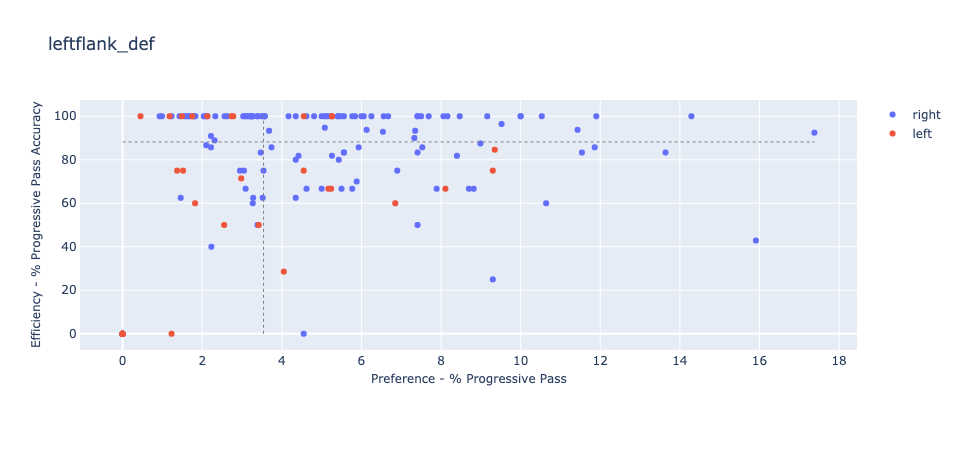

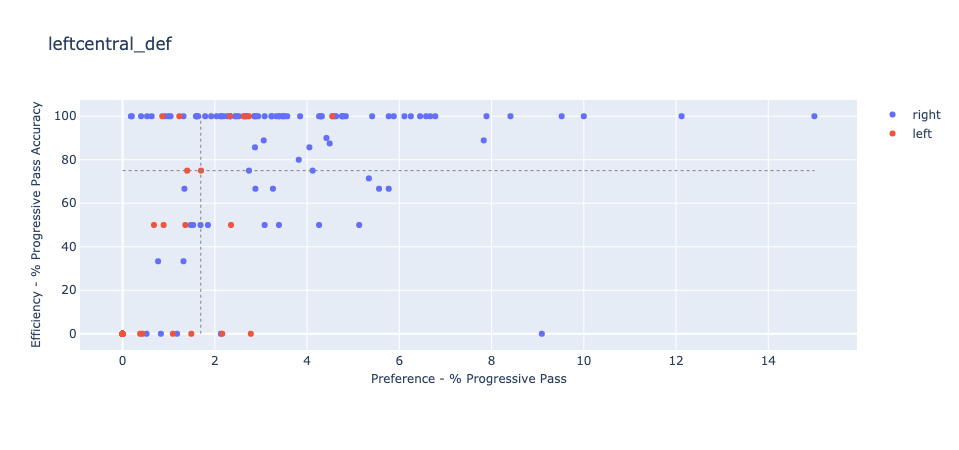

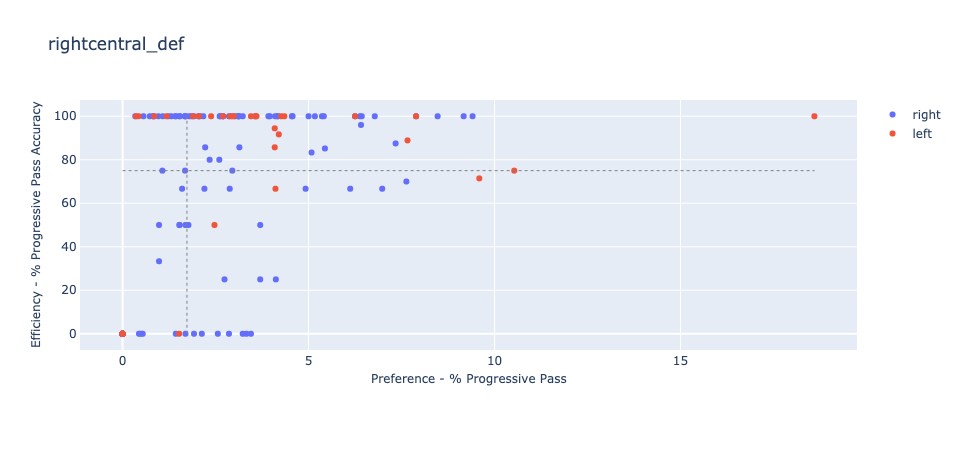

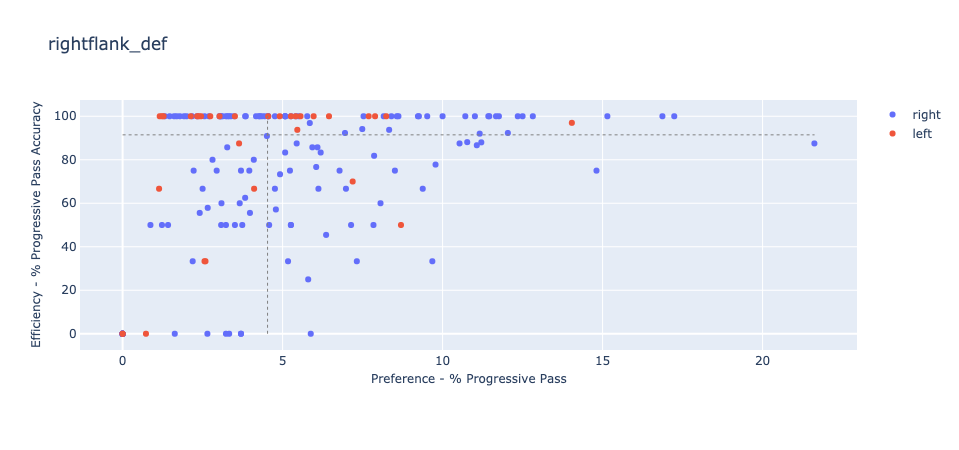

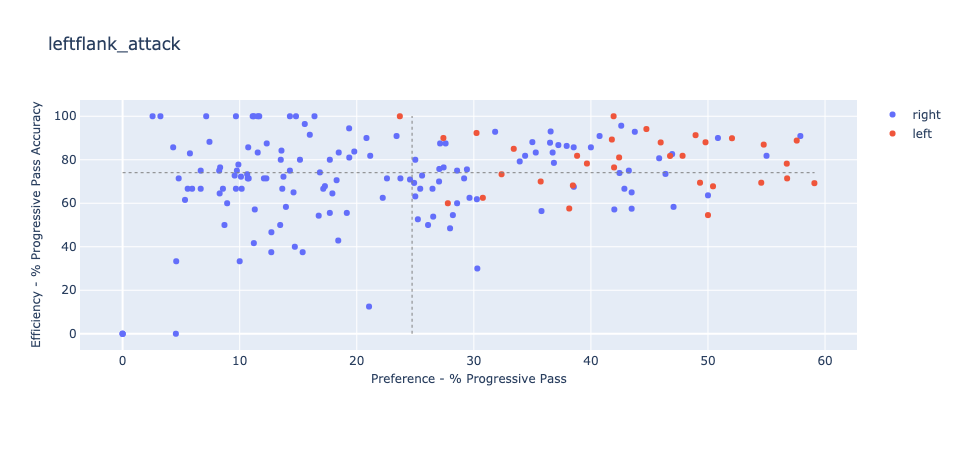

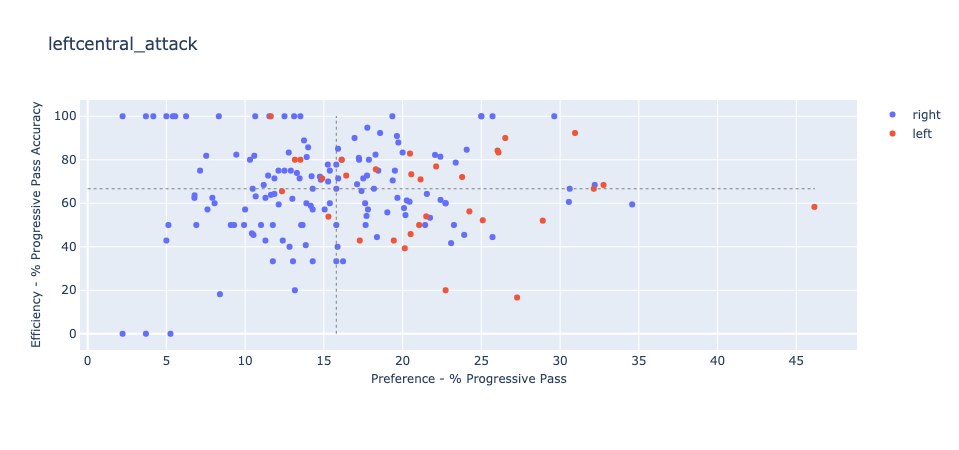

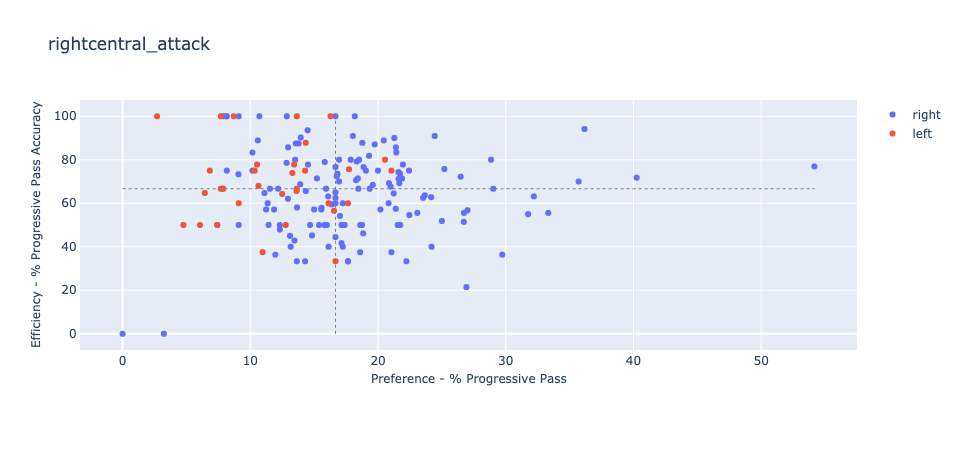

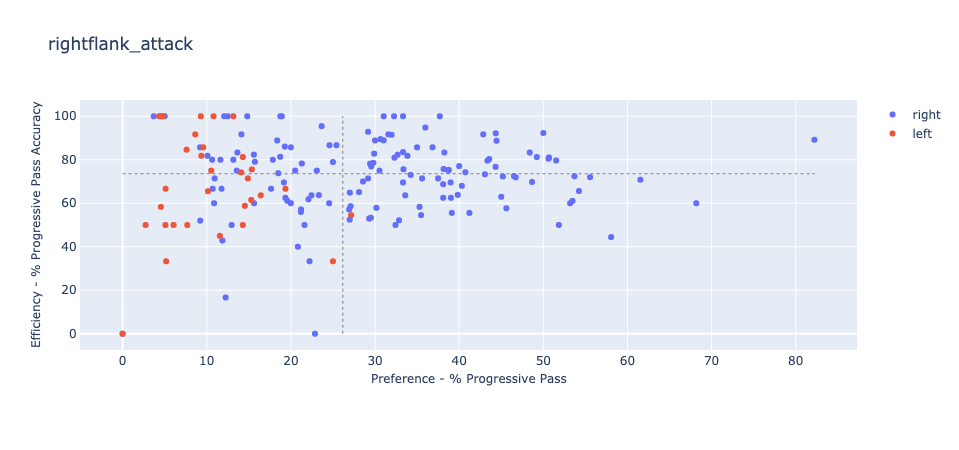

In [93]:
# The graphs have been saved in 'defender_clusters' data folder
plot_preference_accuracy_region(defender_attrs_plot_prefacc)

In [94]:
# defender_attrs_lcb.head()

In [97]:
# Saving the region wise pass and vaep-values dataframe
# defender_attrs.to_pickle('../../FootballPlayerFootedness_copy/data/defender_clusters/defender_attrs_def_region_wise.pkl')

# Generating Offensive Value Added vs Preference Plots For Accurate and Inaccurate Progressive Passes

In [34]:
# defender_attrs_lcb = pd.read_pickle('../data/defender_clusters/defender_attrs_lcb_region_wise.pkl')

In [98]:
# Limiting the number of columns in a dataframe for plotting purpose
defender_attrs_plot = defender_attrs[[
    'player_name', 'team', 'position', 'footedness', 'matches_played',
    'progaccpass', 'proginaccpass', 'prog_acc_region_per_pass',
    'off_acc_region_per_pass', 'prog_inacc_region_per_pass',
    'off_inacc_region_per_pass'
]]

In [99]:
# Considering only those players who have made more than 20 progressive passes throughout the Season 
defender_attrs_plot = defender_attrs_plot.loc[
    defender_attrs_plot['progaccpass'] +
    defender_attrs_plot['proginaccpass'] >= 20]

In [100]:
len(defender_attrs.loc[(defender_attrs['progaccpass'] + defender_attrs['proginaccpass']>=20)])

264

In [101]:
player_names = list(zip(defender_attrs_plot['player_name'].tolist(),defender_attrs_plot['position'].tolist()))
player_names

[('AaronCresswell', 'LB'),
 ('AaronCresswell', 'LCB'),
 ('AaronWanBissaka', 'RB'),
 ('AdamSmith', 'LB'),
 ('AdamSmith', 'RB'),
 ('AdrianMariappa', 'L_CB'),
 ('AdrianMariappa', 'RB'),
 ('AdrianMariappa', 'RCB'),
 ('AdrianMariappa', 'R_CB'),
 ('AhmedHegazi', 'CB'),
 ('AhmedHegazi', 'LCB'),
 ('AhmedHegazi', 'L_CB'),
 ('AhmedHegazi', 'R_CB'),
 ('AlbertoMoreno', 'LB'),
 ('AleksandarDragovic', 'R_CB'),
 ('AlfieMawson', 'LCB'),
 ('AlfieMawson', 'L_CB'),
 ('AllanRomeoNyom', 'LB'),
 ('AllanRomeoNyom', 'RB'),
 ('AndreasChristensen', 'CB'),
 ('AndrewRobertson', 'LB'),
 ('AngeloOgbonna', 'CB'),
 ('AngeloOgbonna', 'LCB'),
 ('AngeloOgbonna', 'L_CB'),
 ('AntonioRudiger', 'LCB'),
 ('AntonioRudiger', 'RCB'),
 ('ArthurMasuaku', 'LB'),
 ('AshleyWilliams', 'CB'),
 ('AshleyWilliams', 'L_CB'),
 ('AshleyWilliams', 'R_CB'),
 ('AshleyYoung', 'LB'),
 ('AshleyYoung', 'RB'),
 ('AymericLaporte', 'L_CB'),
 ('BenChilwell', 'LB'),
 ('BenDavies', 'LB'),
 ('BenMee', 'L_CB'),
 ('BenjaminMendy', 'LB'),
 ('Bruno', 'RB'),


In [102]:
defender_attrs_plot = defender_attrs_plot.loc[defender_attrs_plot['position'].str.contains('CB')]

In [103]:
# Function to plot scatter plots for preference over offensive value addition per accurate/inaccurate 
# progresive pass across regions
def plot_preference_value_region(df,result_type):
    regions = [
        'leftflank_def', 'leftcentral_def', 'rightcentral_def',
        'rightflank_def', 'leftflank_attack', 'leftcentral_attack',
        'rightcentral_attack', 'rightflank_attack'
    ]
    foot2color = {'left': 'rgb(60,48,39)', 'right': 'rgb(215,148,39)'}
    foot_colors = df['footedness'].map(foot2color)
    for i in range(8):
        prog_region_right,prog_region_left = list(), list()
        off_region_right,off_region_left = list(), list()
        player_name_right,player_name_left = list(), list()
        player_position_right,player_position_left = list(), list()
        player_foot_right,player_foot_left = list(), list()
        player_team_right,player_team_left = list(), list()
        df_right = df.loc[df['footedness']=='right']
        df_left = df.loc[df['footedness']=='left']
        if result_type == 'Acc':
            for idx, row in df_right.iterrows():
                prog_region_right.append(row['prog_acc_region_per_pass'][i])
                off_region_right.append(np.round(row['off_acc_region_per_pass'][i],2))
                player_name_right.append(row['player_name'])
                player_position_right.append(row['position'])
                player_team_right.append(row['team'])
            for idx, row in df_left.iterrows():
                prog_region_left.append(row['prog_acc_region_per_pass'][i])
                off_region_left.append(np.round(row['off_acc_region_per_pass'][i],2))
                player_name_left.append(row['player_name'])
                player_position_left.append(row['position'])
                player_team_left.append(row['team'])
        elif result_type == 'Inacc':
            for idx, row in df_right.iterrows():
                prog_region_right.append(row['prog_inacc_region_per_pass'][i])
                off_region_right.append(np.round(row['off_inacc_region_per_pass'][i],2))
                player_name_right.append(row['player_name'])
                player_position_right.append(row['position'])
                player_team_right.append(row['team'])
            for idx, row in df_left.iterrows():
                prog_region_left.append(row['prog_inacc_region_per_pass'][i])
                off_region_left.append(np.round(row['off_inacc_region_per_pass'][i],2))
                player_name_left.append(row['player_name'])
                player_position_left.append(row['position'])
                player_team_left.append(row['team'])
        prog_region = prog_region_right + prog_region_left
        off_region = off_region_right + off_region_left
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(x=prog_region_right,
                       y=off_region_right,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_right,player_position_right,
                                                                  player_team_right,prog_region_right,
                                                                  off_region_right)],
                       hoverinfo = 'text',
                       name='right-footed',
                       mode='markers',
                       ))
        fig.add_trace(
            go.Scatter(x=prog_region_left,
                       y=off_region_left,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_left,player_position_left,
                                                                  player_team_left,prog_region_left,
                                                                  off_region_left)],
                       hoverinfo = 'text',
                       name='left-footed',
                       mode='markers'))
        fig.update_layout(shapes=[
            dict(type='line',
                 yref='y',
                 y0=min(off_region),
                 y1=max(off_region),
                 xref='x',
                 x0=statistics.median(prog_region),
                 x1=statistics.median(prog_region),
                 line=dict(color="Grey", width=1, dash="dot")),
            dict(type='line',
                 yref='y',
                 y0=statistics.median(off_region),
                 y1=statistics.median(off_region),
                 xref='x',
                 x0=0,
                 x1=max(prog_region),
                 line=dict(color="Grey", width=1, dash="dot"))
        ])
        fig.update_layout(annotations=[
            dict(x=0.5,
                 y=-0.15,
                 showarrow=False,
                 text='Preference - % Progressive Passes '+ result_type,
                 xref="paper",
                 yref="paper"),
            dict(
                x=-0.1,
                y=0.5,
                showarrow=False,
                text=
                'Offensive Value Added per progressive pass <br>(scaled to 10000)',
                textangle=-90,
                xref="paper",
                yref="paper")
        ],
                          autosize=True,
                          margin=dict(b=100),
                          title_text=str(regions[i]))
        fig.show()
        #fig.write_html(f"../data/defender_clusters/offvalue_accinaccpass_plots/{str(regions[i])}_{result_type}.html")

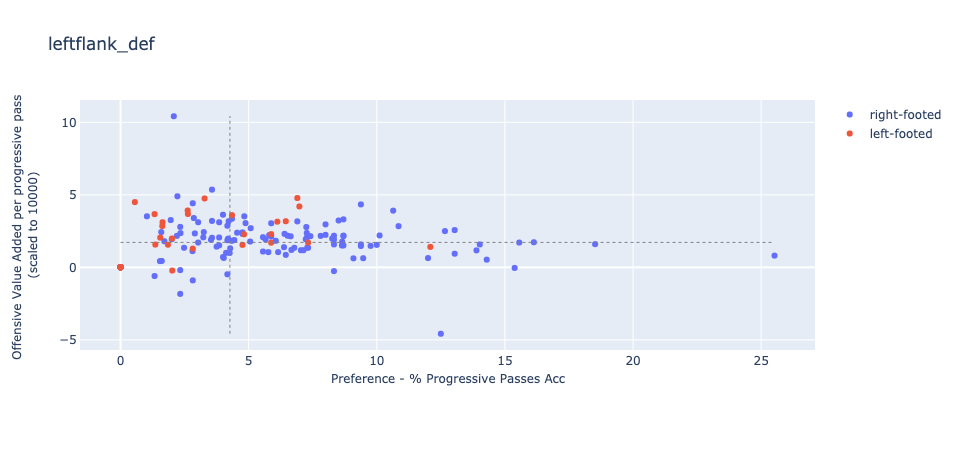

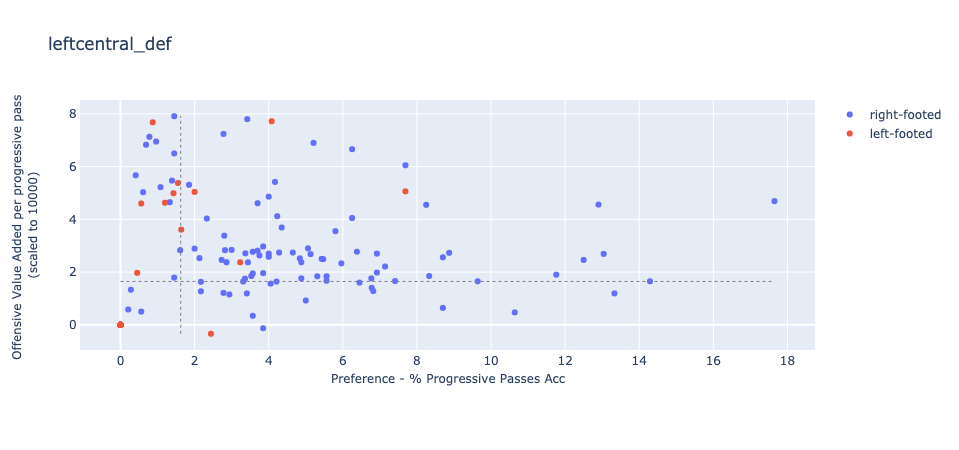

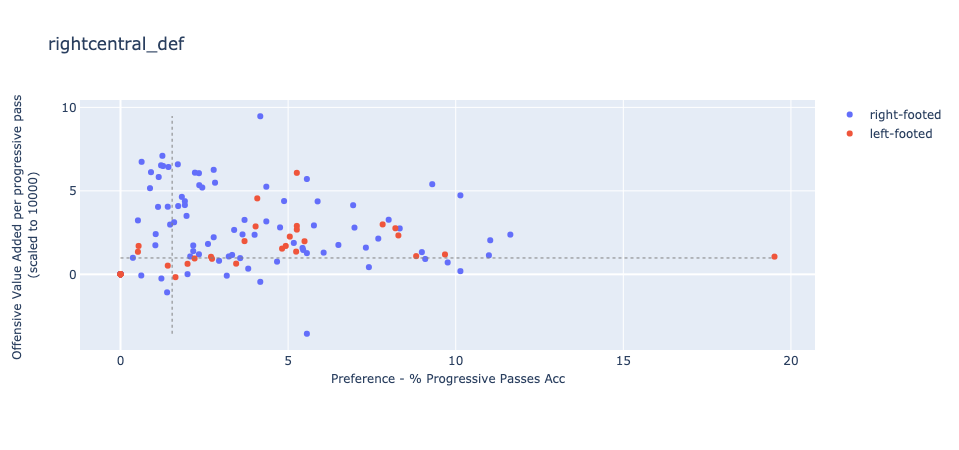

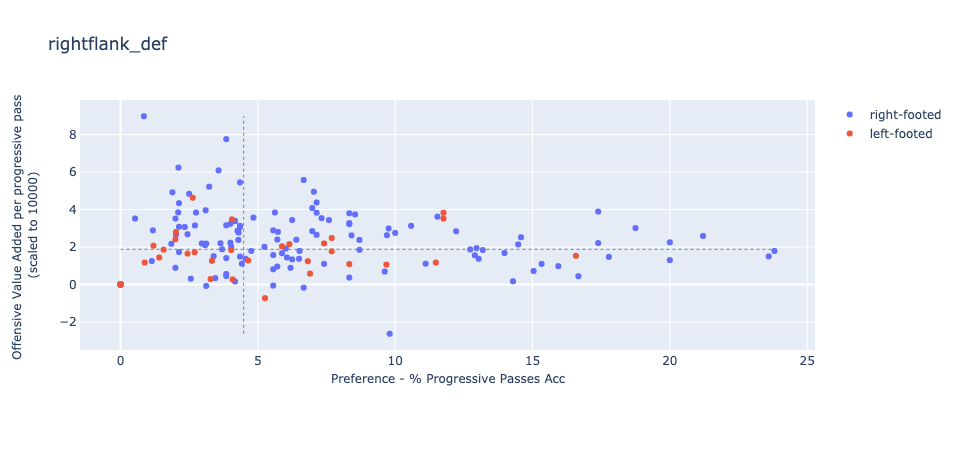

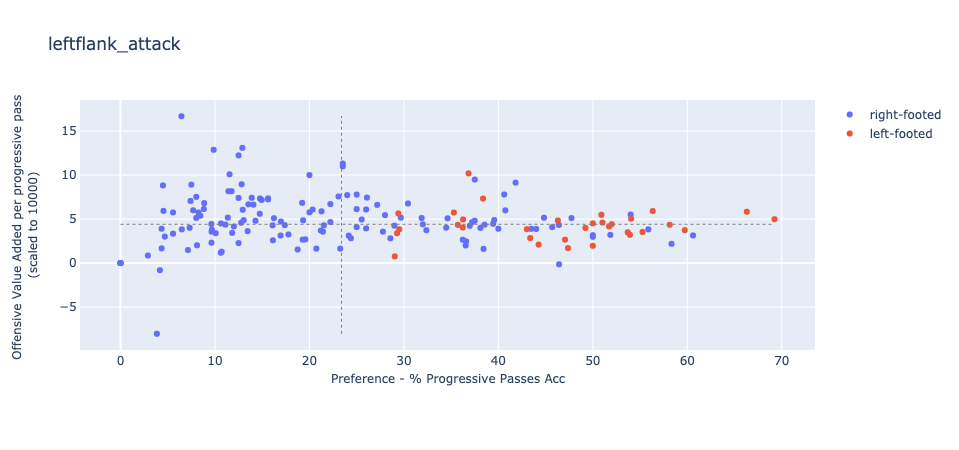

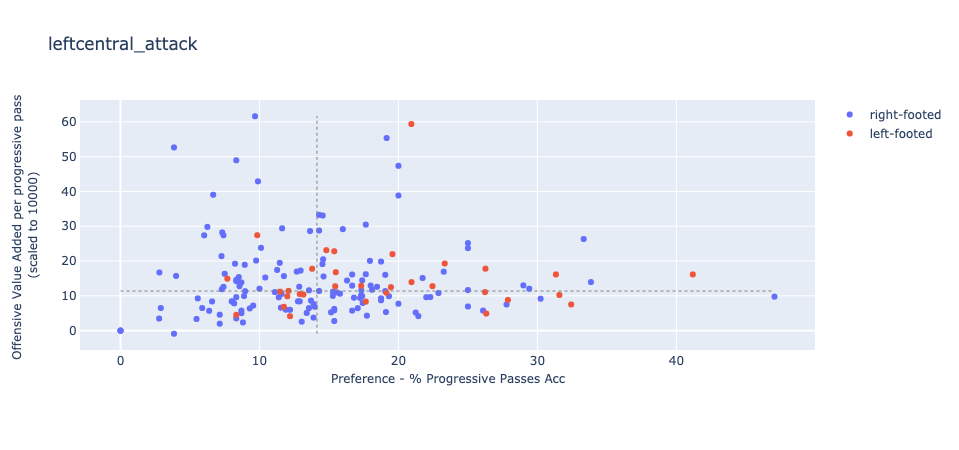

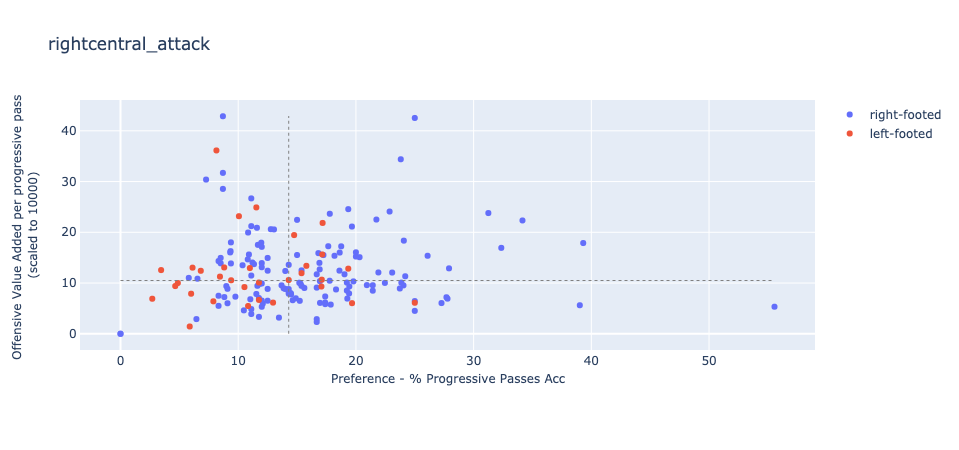

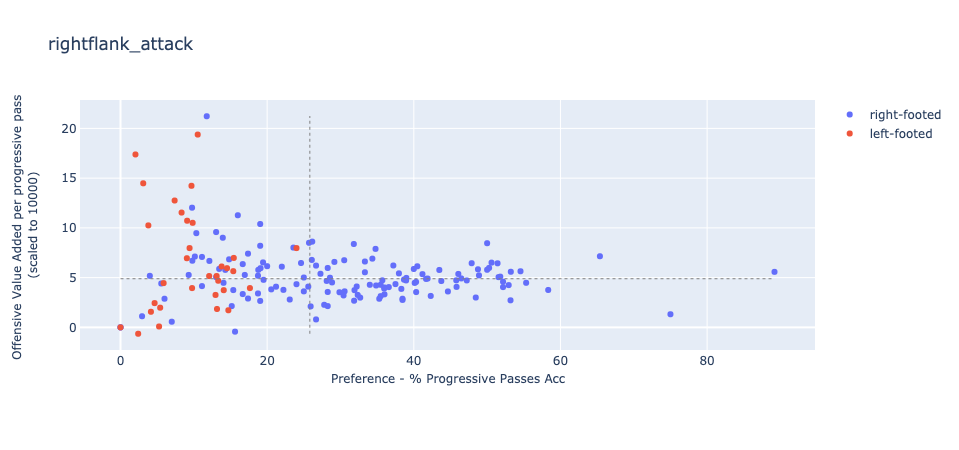

In [104]:
# The graphs have been saved in 'defender_clusters' data folder
plot_preference_value_region(defender_attrs_plot, result_type = 'Acc')

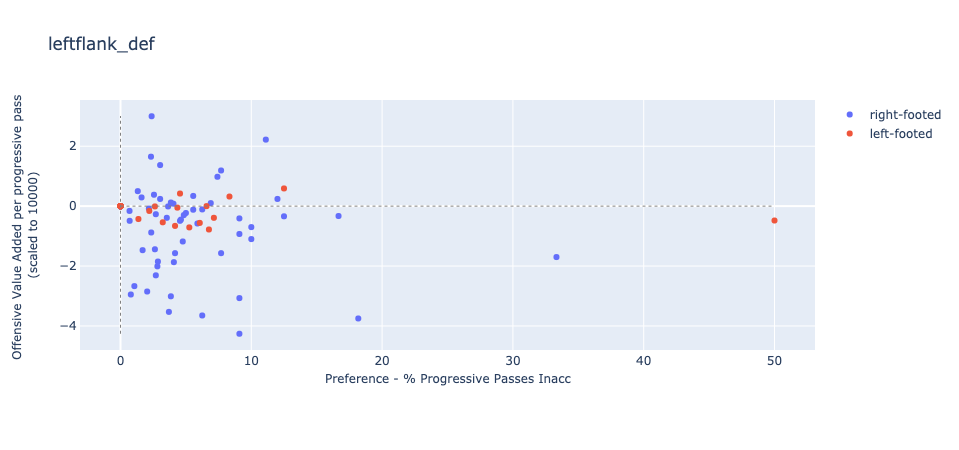

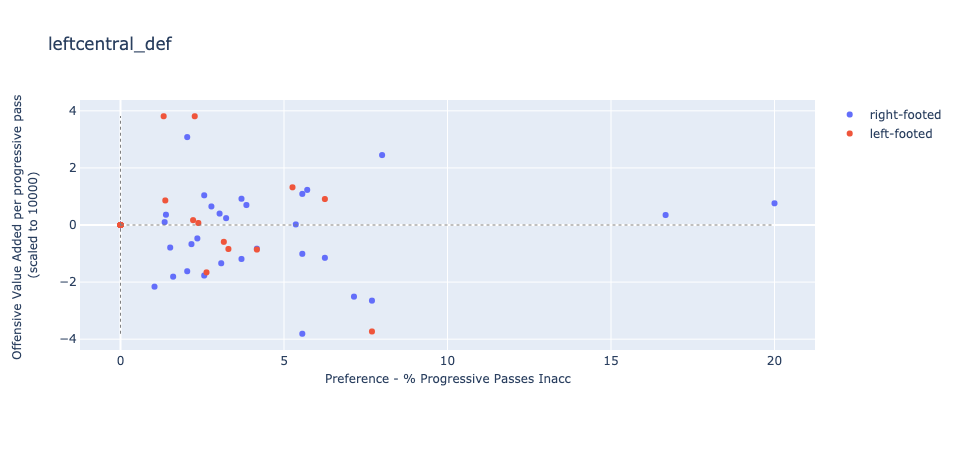

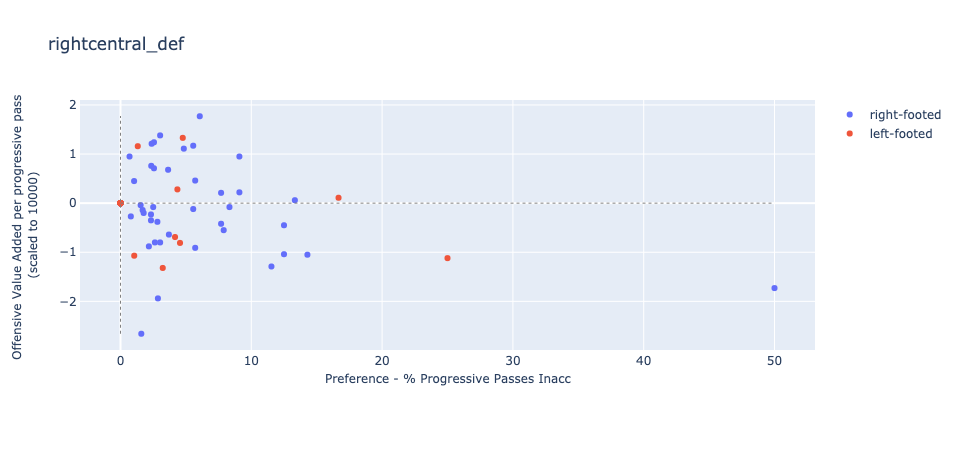

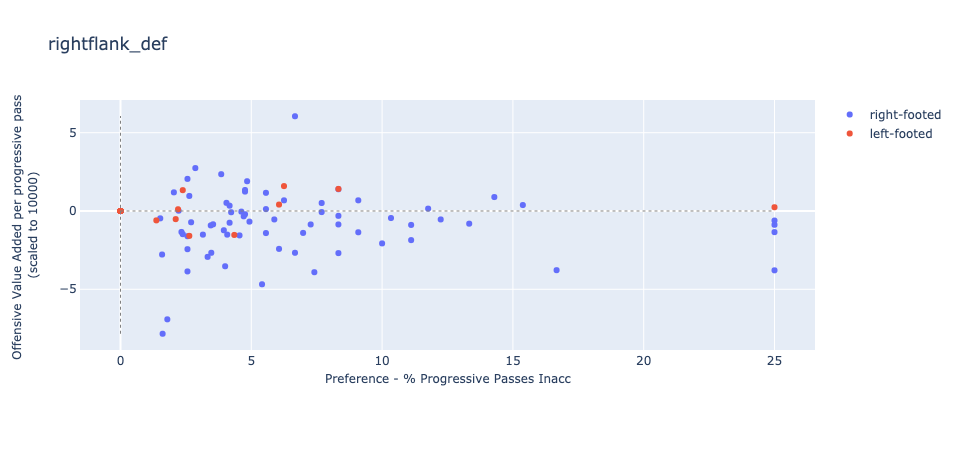

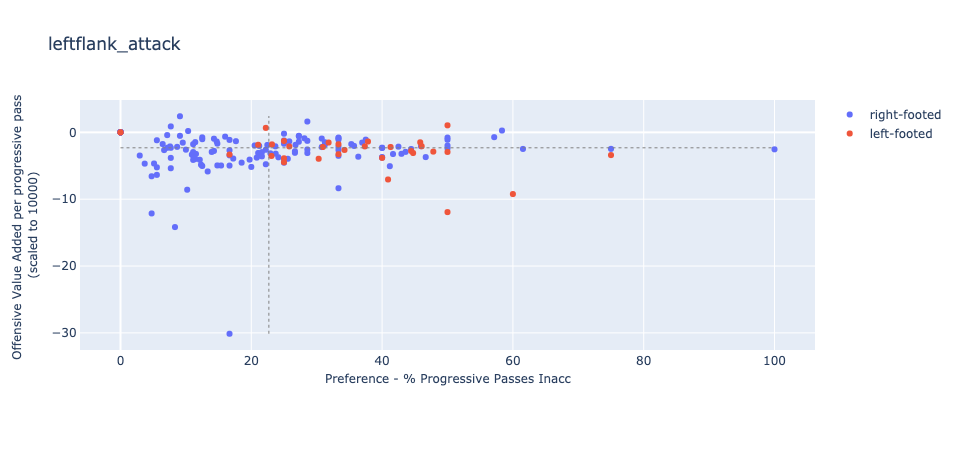

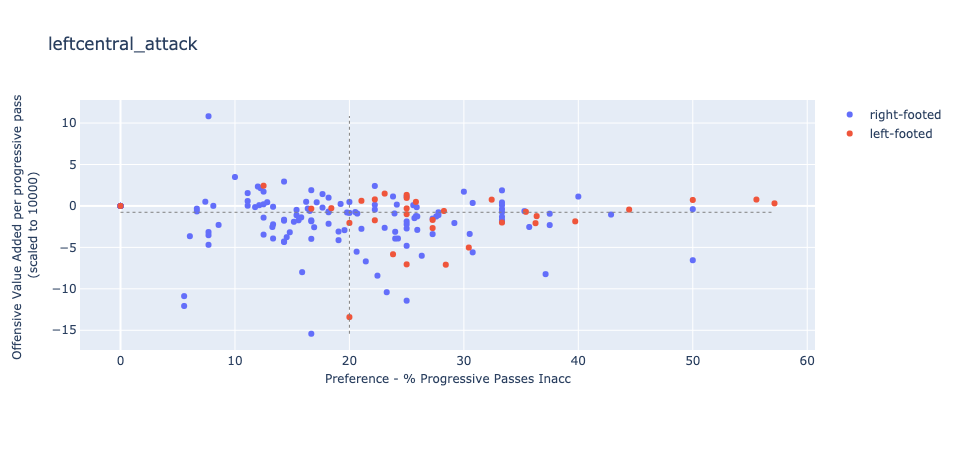

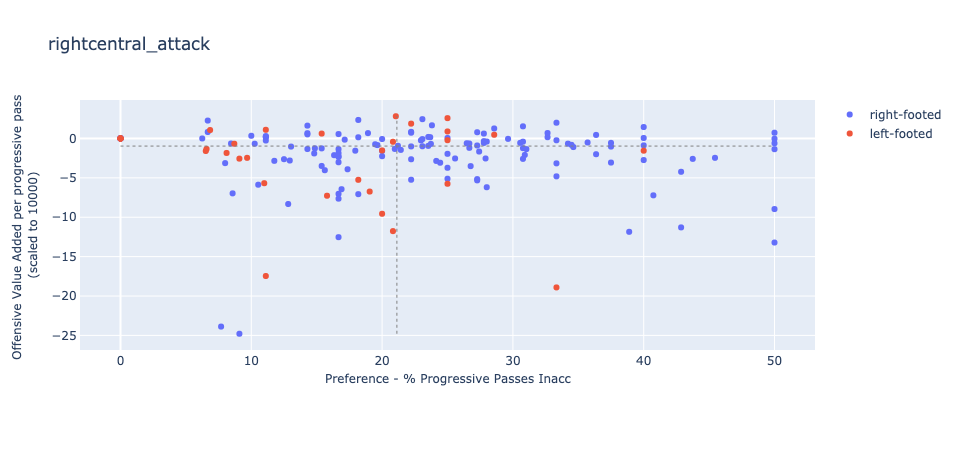

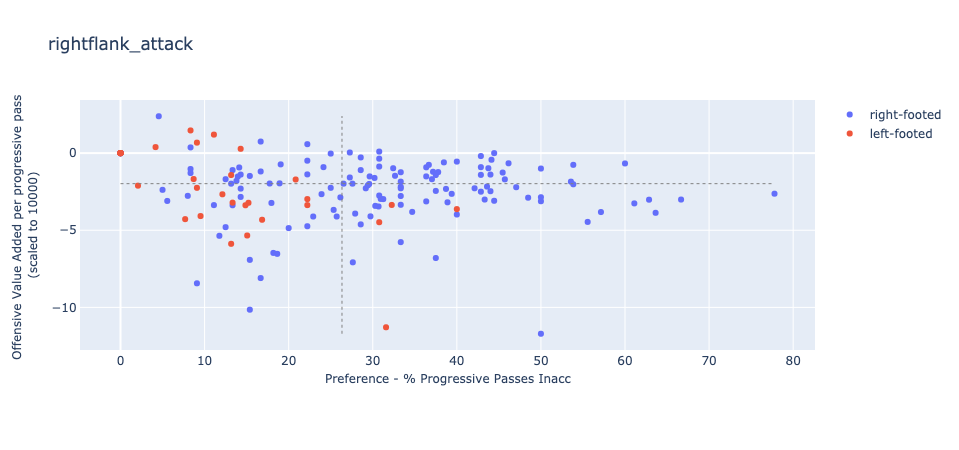

In [105]:
# The graphs have been saved in 'defender_clusters' data folder
plot_preference_value_region(defender_attrs_plot, result_type = 'Inacc')

## Generating Cumulative Offensive Values Added vs Preference Plots For Progressive Passes


In [106]:
# Function to calculate total offensive value added per progressive pass in each region.
# It takes into account both accurate and inaccurate progressive passes
def off_cumulative_preference(progacclocs,proginacclocs, off_acc, off_inacc):
    progacclocs_start, progacclocs_end = getstartend(progacclocs)
    prog_acclocs_x, prog_acclocs_y = getxy(progacclocs_end)
    off_acc_region = get_vaep_region(prog_acclocs_x,prog_acclocs_y,off_acc)
    proginacclocs_start,proginacclocs_end = getstartend(proginacclocs)
    prog_inacclocs_x, prog_inacclocs_y = getxy(proginacclocs_end)
    off_inacc_region = get_vaep_region(prog_inacclocs_x,prog_inacclocs_y,off_inacc)
    prog_acc_region = get_pass_region(prog_acclocs_x,prog_acclocs_y)
    prog_inacc_region = get_pass_region(prog_inacclocs_x,prog_inacclocs_y)
    total_off_region = [off_acc_region[i] + off_inacc_region[i] for i in range(8)]
    total_prog_region = [prog_acc_region[i] + prog_inacc_region[i] for i in range(8)]
    total_off_region_per_pass = list()
    for i in range(8):
        if total_prog_region[i]!=0:
            total_off_region_per_pass.append((total_off_region[i]/total_prog_region[i])*1000)
        else:
            total_off_region_per_pass.append(0)
    return pd.Series([total_off_region_per_pass])

In [107]:
defender_attrs['total_off_region_per_pass'] = defender_attrs.apply(
    lambda x: off_cumulative_preference(x['progaccpassloc'], x[
        'proginaccpassloc'], x['progaccpassoff'], x['proginaccpassoff']),
    axis=1)

In [108]:
# Limiting the data by taking into account players who have made atleast 20 progressive passes
defender_attrs_plot = defender_attrs.loc[
    defender_attrs['progaccpass'] +
    defender_attrs['proginaccpass'] >= 20]

In [109]:
defender_attrs_plot = defender_attrs_plot.loc[defender_attrs_plot['position'].str.contains('CB')]

In [110]:
# Function to plot preference for progressive passes vs offensive value added per progressive pass in each region
def plot_cumulativeoff_preference(df):
    regions = [
        'leftflank_def', 'leftcentral_def', 'rightcentral_def',
        'rightflank_def', 'leftflank_attack', 'leftcentral_attack',
        'rightcentral_attack', 'rightflank_attack'
    ]
    foot2color = {'left': 'rgb(60,48,39)', 'right': 'rgb(215,148,39)'}
    foot_colors = df['footedness'].map(foot2color)
    
    for i in range(8):
        prog_region_right,prog_region_left = list(), list()
        off_region_right,off_region_left = list(), list()
        player_name_right,player_name_left = list(), list()
        player_position_right,player_position_left = list(), list()
        player_foot_right,player_foot_left = list(), list()
        player_team_right,player_team_left = list(), list()
        df_right = df.loc[df['footedness']=='right']
        df_left = df.loc[df['footedness']=='left']
        for idx, row in df_right.iterrows():
            prog_region_right.append(row['progpreference_per_region'][i])
            off_region_right.append(row['total_off_region_per_pass'][i])
            player_name_right.append(row['player_name'])
            player_position_right.append(row['position'])
            player_team_right.append(row['team'])
        for idx, row in df_left.iterrows():
            prog_region_left.append(row['progpreference_per_region'][i])
            off_region_left.append(row['total_off_region_per_pass'][i])
            player_name_left.append(row['player_name'])
            player_position_left.append(row['position'])
            player_team_left.append(row['team'])
        prog_region = prog_region_right + prog_region_left
        off_region = off_region_right + off_region_left
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(x=prog_region_right,
                       y=off_region_right,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_right,player_position_right,
                                                                  player_team_right,prog_region_right,
                                                                  off_region_right)],
                       hoverinfo = 'text',
                       name='right-footed',
                       mode='markers'))
        fig.add_trace(
            go.Scatter(x=prog_region_left,
                       y=off_region_left,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_left,player_position_left,
                                                                  player_team_left,prog_region_left,
                                                                  off_region_left)],
                       hoverinfo = 'text',
                       name='left-footed',
                       mode='markers'))
        fig.update_layout(shapes=[
            dict(type='line',
                 yref='y',
                 y0=min(off_region),
                 y1=max(off_region),
                 xref='x',
                 x0=statistics.median(prog_region),
                 x1=statistics.median(prog_region),
                 line=dict(color="Grey", width=1, dash="dot")),
            dict(type='line',
                 yref='y',
                 y0=statistics.median(off_region),
                 y1=statistics.median(off_region),
                 xref='x',
                 x0=0,
                 x1=max(prog_region),
                 line=dict(color="Grey", width=1, dash="dot"))
        ])
        fig.update_layout(annotations=[
            dict(x=0.5,
                 y=-0.15,
                 showarrow=False,
                 text='Preference - % Progressive Pass',
                 xref="paper",
                 yref="paper"),
            dict(x=-0.1,
                 y=0.5,
                 showarrow=False,
                 text='Offensive value added per progressive pass<br>(scaled by 1000)',
                 textangle=-90,
                 xref="paper",
                 yref="paper")
        ])
        fig.update_layout(autosize=True,
                          margin=dict(b=100),
                          title_text=str(regions[i]),
                          showlegend = True)
        fig.show()
        #fig.write_html(f"../data/defender_clusters/offvalue_preference_plots/{str(regions[i])}.html")

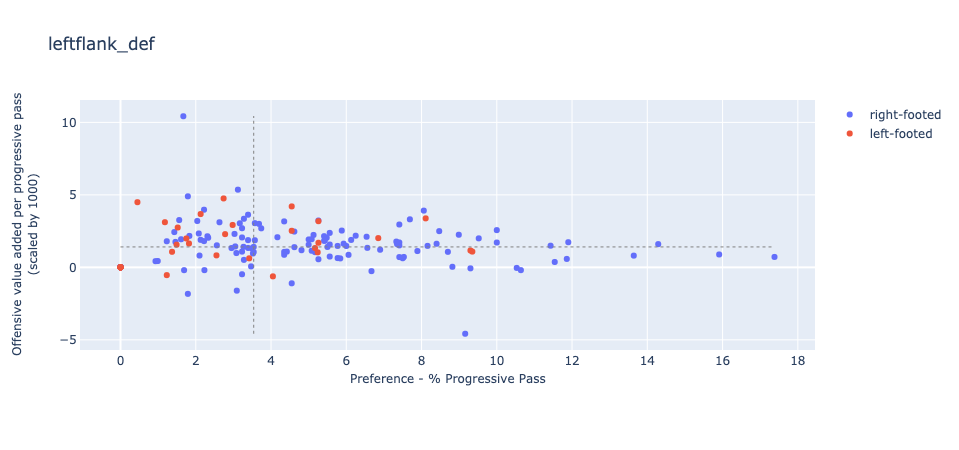

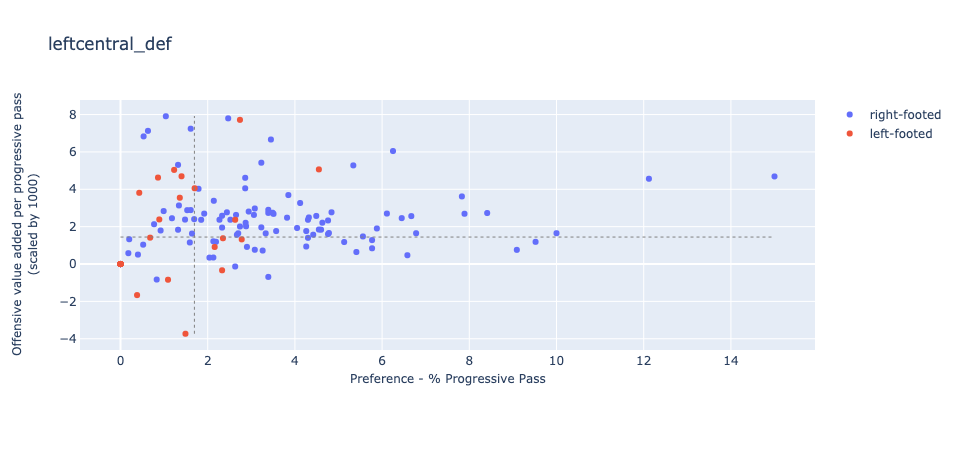

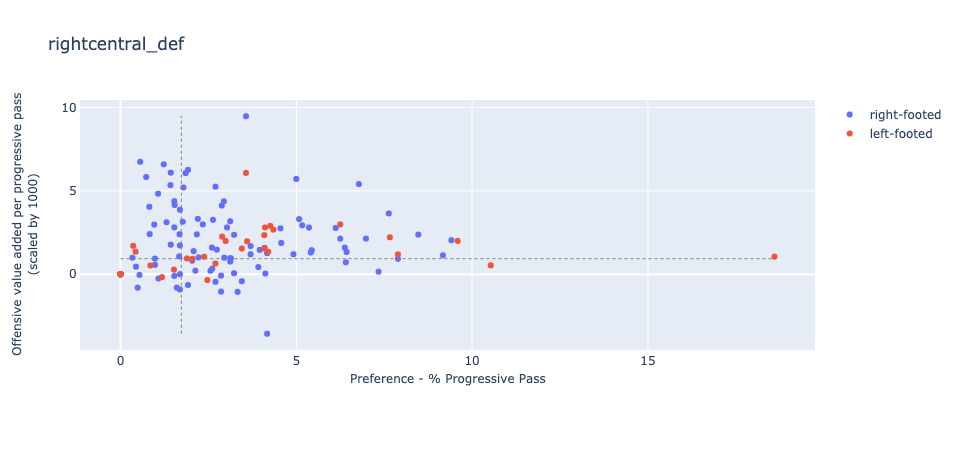

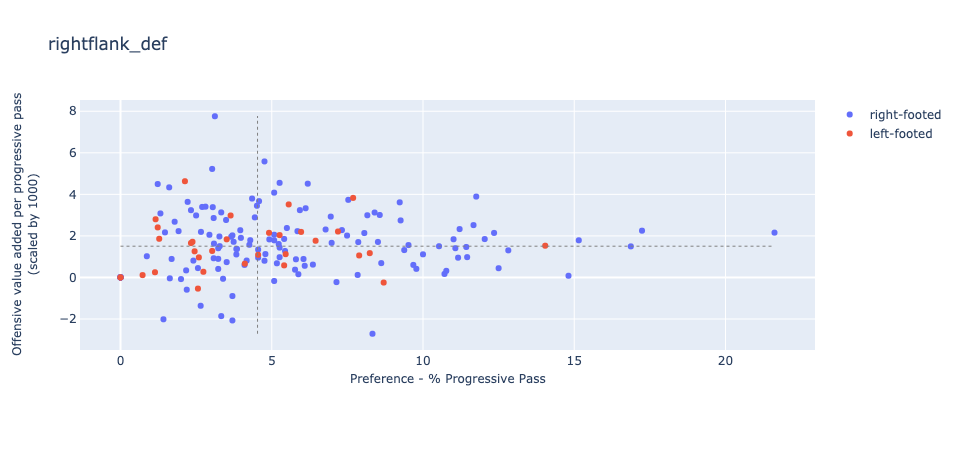

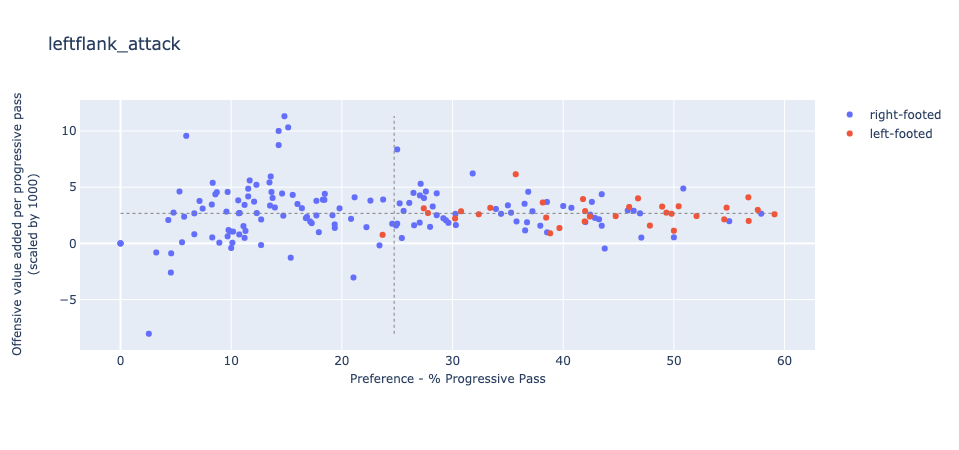

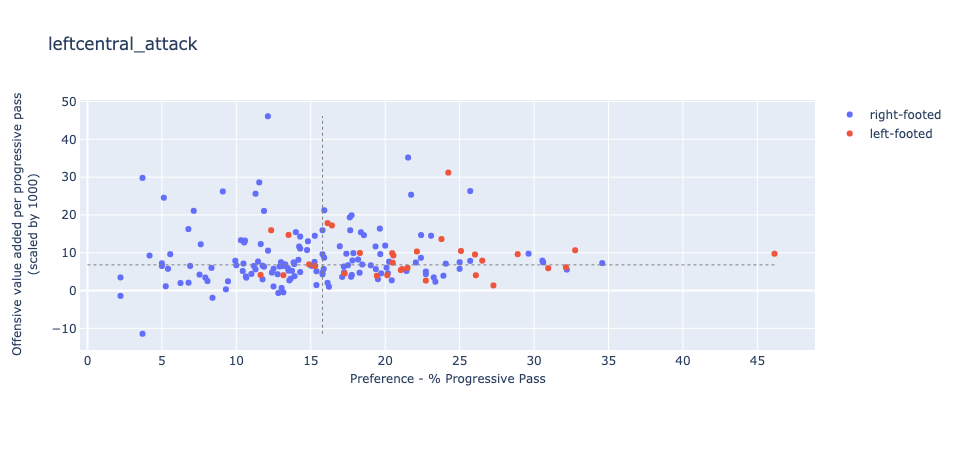

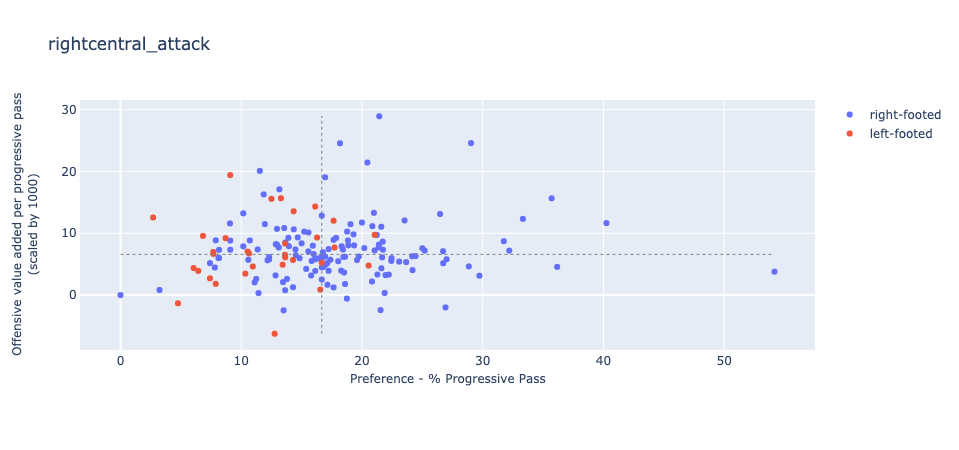

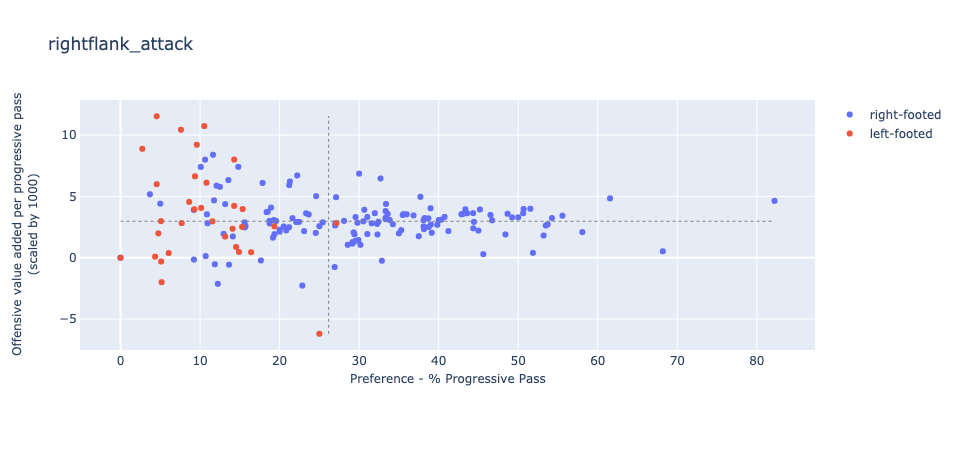

In [111]:
# The graphs have been saved in 'defender_clusters' data folder
plot_cumulativeoff_preference(defender_attrs_plot)

In [113]:
# Saving dataframe in data folder
defender_attrs.to_pickle('../../FootballPlayerFootedness_copy/data/defender_clusters/defender_attrs_def_region_wise.pkl')

# Appendix

**Column Name Meanings for `defender_attrs`**

1. `player_name`: Player Name
2. `team`: Team the Player played for
3. `position`: Position of the Player in the defensive line-up - <br>
    `LCB`: Left Center Back in 4 ATB formation<br>
    `L_CB`: Left Center Back in 3/5 ATB formation<br> 
4. `footedness`: Dominant foot of the player<br>
5. `matches_played`: Total Matches Played by the player for the respective `team` + `position` <br>
6. `passes`: Total Passes made by the player in these `matches_played`<br>
7. `accpass`: Total Accurate Passes made by the player in these `matches_played`<br>
8. `progaccpass`: Total Accurate Progressive Passes made by the player in these `matches_played`<br>
9. `proginaccpass`: Total Inaccurate Progressive Passes made by the player in these `matches_played`<br>
10. `accpassloc`: End Point Locations of all the Accurate Passes made by the player in these `matches_played`<br>
11. `inaccpassloc`: End Point Locations of all the Inaccurate Passes made by the player in these `matches_played`<br>
12. `progaccpassloc`: End Point Locations of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
13. `proginaccpassloc`: End Point Locations of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
14. `accpassvaep`: `VAEP` Value of all the Accurate Passes made by the player in these `matches_played`<br>
15. `inaccpassvaep`: `VAEP` Value of all the Inaccurate Passes made by the player in these `matches_played`<br>
16. `progaccpassvaep`: `VAEP` Value of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
17. `proginaccpassvaep`: `VAEP` Value of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
18. `accpassoff`: `Offensive - VAEP Coefficient` Value of all the Accurate Passes made by the player in these `matches_played`<br>
19. `inaccpassoff`: `Offensive - VAEP Coefficient` Value of all the Inaccurate Passes made by the player in these `matches_played`<br>
20. `progaccpassoff`: `Offensive - VAEP Coefficient` Value of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
21. `proginaccpassoff`: `Offensive - VAEP Coefficient` Value of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
22. `accpassdef`: `Defensive - VAEP Coefficient` Value of all the Accurate Passes made by the player in these `matches_played`<br>
23. `inaccpassdef`: `Defensive - VAEP Coefficient` Value of all the Inaccurate Passes made by the player in these `matches_played`<br>
24. `progaccpassdef`: `Defensive - VAEP Coefficient` Value of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
25. `proginaccpassdef`: `Defensive - VAEP Coefficient` Value of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
26. `prog_acc_region_per_pass`: Ratio of (Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
27. `vaep_acc_region_per_pass`: Ratio of (`VAEP` Value added by the Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
28. `prog_inacc_region_per_pass`: Ratio of (Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
29. `vaep_inacc_region_per_pass`: Ratio of (`VAEP` Value added by the Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
30. `off_acc_region_per_pass`: Ratio of (`Offensive - VAEP Coefficient` Value added by the Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
31. `off_inacc_region_per_pass`: Ratio of (`Offensive - VAEP Coefficient` Value added by the Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
32. `def_acc_region_per_pass`: Ratio of (`Defensive - VAEP Coefficient` Value added by the Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
33. `def_inacc_region_per_pass`: Ratio of (`Defensive - VAEP Coefficient` Value added by the Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
34. `progpreference_per_region`: Ratio of (Total Progressive Passes in each of the 8 regions of the Field), to the (Total Progressive Passes) made by the Player cumulated for these `matches_played`. Indicates `Preference` of the Player to pass in each of the Regions. <br>
35. `progaccurary_per_region`: Ratio of (Total Accurate Progressive Passes in each of the 8 regions of the Field), to the (Total Progressive Passes in each of the 8 regions of the field) made by the Player cumulated for these `matches_played`. Indicates the Accuracy of the Player in each of the Regions. <br>
36. `total_off_region_per_region` : Ratio of (Total `Offensive - VAEP Coefficient` Value added by Total Progressive Passes in each of the 8 regions of the field), to the (Total Progressive Passes) made by the Player cumulated for these `matches_played`

# Generating Universal DF for Player Profiles 

In [55]:
defender_attrs.head(20)

index         player_name            team position footedness  \
0       0      AaronCresswell        West Ham       LB       left   
1       1      AaronCresswell        West Ham      LCB       left   
2       2     AaronWanBissaka  Crystal Palace       RB      right   
3       3           AdamSmith     Bournemouth       LB      right   
4       4           AdamSmith     Bournemouth       RB      right   
5       5           AdamSmith     Bournemouth      RWB      right   
6       6      AdrianMariappa         Watford       LB      right   
7       7      AdrianMariappa         Watford     L_CB      right   
8       8      AdrianMariappa         Watford       RB      right   
9       9      AdrianMariappa         Watford      RCB      right   
10     10      AdrianMariappa         Watford     R_CB      right   
11     11         AhmedHegazi       West Brom       CB      right   
12     12         AhmedHegazi       West Brom      LCB      right   
13     13         AhmedHegazi       West Brom     L_CB      right   
14     14         AhmedHegazi       West Brom     R_CB      right   
17     17       AlbertoMoreno       Liverpool       LB       left   
18     18  AleksandarDragovic       Leicester       RB      right   
19     19  AleksandarDragovic       Leicester      RCB      right   
20     20  AleksandarDragovic       Leicester     R_CB      right   
21     21         AlfieMawson         Swansea      LCB      right   

    matches_played  passes  accpass  progaccpass  proginaccpass  \
0              7.0     275      203           43             47   
1             20.0     796      644          184             91   
2              7.0     226      165           39             20   
3              3.0     146      120           27             10   
4             10.0     451      387           71             35   
5              1.0      17       10            2              3   
6              1.0      40       33           11              4   
7              5.0     179      144           29             17   
8              3.0      92       67           12             14   
9             11.0     416      348           71             26   
10             4.0     131      112           27              8   
11             7.0     235      200           45             14   
12             3.0     108       85           25             14   
13            16.0     438      347           72             46   
14            12.0     347      266           70             38   
17            14.0     780      659          123             64   
18             1.0      34       26            3              5   
19             1.0      20       16            1              1   
20             5.0     202      179           36             11   
21            19.0     758      620          150             74   

                                           accpassloc  \
0   [[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58.4...   
1   [[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....   
2   [[[60.32, 11.56], [70.72, 8.84]], [[55.12, 11....   
3   [[[15.6, 59.84], [22.88, 54.4]], [[19.76, 61.2...   
4   [[[28.08, 4.76], [40.56, 20.4]], [[31.2, 13.6]...   
5   [[[98.8, 19.72], [93.6, 25.84]], [[33.28, 3.4]...   
6   [[[61.36, 65.28], [68.64, 60.52]], [[65.52, 64...   
7   [[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....   
8   [[[65.52, 2.04], [73.84, 2.04]], [[61.36, 4.08...   
9   [[[31.2, 10.2], [52.0, 19.72]], [[27.04, 9.52]...   
10  [[[30.16, 14.96], [70.72, 10.2]], [[38.48, 9.5...   
11  [[[26.0, 31.28], [30.16, 44.88]], [[30.16, 27....   
12  [[[30.16, 59.84], [8.32, 52.36]], [[13.52, 45....   
13  [[[31.2, 44.88], [41.6, 44.2]], [[46.8, 48.96]...   
14  [[[21.84, 7.48], [22.88, 51.0]], [[28.08, 23.8...   
17  [[[71.76, 53.04], [93.6, 15.64]], [[71.76, 49....   
18  [[[5.2, 4.08], [5.2, 14.96]], [[29.12, 5.44], ...   
19  [[[16.64, 9.52], [20.8, 0.68]], [[18.72, 6.12]...   
20  [[[24.96, 5.44], [42.64, 19.04]], [[33.28, 13....   
21  [[

In [56]:
defender_attrs.columns[2:]

Index(['team', 'position', 'footedness', 'matches_played', 'passes', 'accpass',
       'progaccpass', 'proginaccpass', 'accpassloc', 'inaccpassloc',
       'progaccpassloc', 'proginaccpassloc', 'accpassvaep', 'inaccpassvaep',
       'progaccpassvaep', 'proginaccpassvaep', 'accpassoff', 'inaccpassoff',
       'progaccpassoff', 'proginaccpassoff', 'accpassdef', 'inaccpassdef',
       'progaccpassdef', 'proginaccpassdef', 'prog_acc_region_per_pass',
       'vaep_acc_region_per_pass', 'prog_inacc_region_per_pass',
       'vaep_inacc_region_per_pass', 'off_acc_region_per_pass',
       'off_inacc_region_per_pass', 'def_acc_region_per_pass',
       'def_inacc_region_per_pass', 'progpreference_per_region',
       'progaccuracy_per_region', 'total_off_region_per_pass'],
      dtype='object')

In [57]:
play = defender_attrs['team'].groupby(defender_attrs.player_name).apply(list).reset_index()
s = list(defender_attrs.columns[3:])
for i in range(len(s)):
    play1 = defender_attrs[s[i]].groupby(defender_attrs.player_name).apply(list).reset_index()
    play = pd.concat([play, play1.drop(columns=['player_name'])], axis=1)

In [58]:
play.head()

player_name                                           team  \
0   AaronCresswell                           [West Ham, West Ham]   
1  AaronWanBissaka                               [Crystal Palace]   
2        AdamSmith        [Bournemouth, Bournemouth, Bournemouth]   
3   AdrianMariappa  [Watford, Watford, Watford, Watford, Watford]   
4      AhmedHegazi   [West Brom, West Brom, West Brom, West Brom]   

                    position                           footedness  \
0                  [LB, LCB]                         [left, left]   
1                       [RB]                              [right]   
2              [LB, RB, RWB]                [right, right, right]   
3  [LB, L_CB, RB, RCB, R_CB]  [right, right, right, right, right]   
4      [CB, LCB, L_CB, R_CB]         [right, right, right, right]   

               matches_played                   passes  \
0                 [7.0, 20.0]               [275, 796]   
1                       [7.0]                    [226]   
2            [3.0, 10.0, 1.0]           [146, 451, 17]   
3  [1.0, 5.0, 3.0, 11.0, 4.0]  [40, 179, 92, 416, 131]   
4      [7.0, 3.0, 16.0, 12.0]     [235, 108, 438, 347]   

                   accpass           progaccpass       proginaccpass  \
0               [203, 644]             [43, 184]            [47, 91]   
1                    [165]                  [39]                [20]   
2           [120, 387, 10]           [27, 71, 2]         [10, 35, 3]   
3  [33, 144, 67, 348, 112]  [11, 29, 12, 71, 27]  [4, 17, 14, 26, 8]   
4      [200, 85, 347, 266]      [45, 25, 72, 70]    [14, 14, 46, 38]   

                                          accpassloc  \
0  [[[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58....   
1  [[[[60.32, 11.56], [70.72, 8.84]], [[55.12, 11...   
2  [[[[15.6, 59.84], [22.88, 54.4]], [[19.76, 61....   
3  [[[[61.36, 65.28], [68.64, 60.52]], [[65.52, 6...   
4  [[[[26.0, 31.28], [30.16, 44.88]], [[30.16, 27...   

                                        inaccpassloc  \
0  [[[[22.88, 65.28], [31.2, 63.24]], [[24.96, 61...   
1  [[[[86.32, 22.44], [87.36, 25.84]], [[98.8, 10...   
2  [[[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.7...   
3  [[[[36.4, 59.84], [69.68, 53.04]], [[34.32, 59...   
4  [[[[10.4, 4.08], [39.52, 6.8]], [[28.08, 35.36...   

                                      progaccpassloc  \
0  [[[[73.84 66.64], [94.64 63.92]], [[63.44 55.0...   
1  [[[[60.32 11.56], [70.72  8.84]], [[83.2  12.9...   
2  [[[[58.24 53.04], [70.72 62.56]], [[74.88 41.4...   
3  [[[[65.52 64.6 ], [71.76 53.04]], [[33.28 66.6...   
4  [[[[30.16 27.2 ], [56.16 11.56]], [[33.28 49.6...   

                                    proginaccpassloc  \
0  [[[[24.96 61.2 ], [49.92 37.4 ]], [[40.56 64.6...   
1  [[[[30.16  6.8 ], [70.72  0.  ]], [[57.2  3.4]...   
2  [[[[67.6 13.6], [74.88 33.32]], [[44.72  2.72]...   
3  [[[[36.4  59.84], [69.68 53.04]], [[21.84 46.2...   
4  [[[[28.08 35.36], [70.72 59.16]], [[70.72 55.7...   

                                         accpassvaep  \
0  [[-0.0060007767751812935, 0.014951384626328945...   
1  [[0.0027392818592488766, -0.001966726733371615...   
2  [[-0.002463837619870901, -0.000103571685031056...   
3  [[0.0019778460264205933, 0.007455416955053806,...   
4  [[0.0009711573366075754, 0.0038739899173378944...   

                                       inaccpassvaep  \
0  [[-0.005001368001103401, 0.0014556727837771177...   
1  [[-0.02877645380795002, -0.01624043844640255, ...   
2  [[-0.007104361429810524, 1.648860052227974e-05...   
3  [[-0.0015141947660595179, 0.005038164090365171...   
4  [[0.0013885477092117071, -0.0052089998498559, ...   

                                     progaccpassvaep  \
0  [[0.010874261148273945, -0.0008622575551271439...   
1  [[0.0027392818592488766, -0.011097729206085205...   
2  [[-0.0019909068942070007, -0.00389313790947198...   
3  [[0.007455416955053806, 0.014729855582118034, ...   
4  [[0.0038739899173378944, 0.0045881327241659164...   

                                   p

In [59]:
len(play)

165

In [60]:
len(defender_attrs.player_name.unique())

165

In [62]:
play.to_pickle('../../FootballPlayerFootedness_copy/data/defender_clusters/defender_attrs_uni.pkl')